## Setup

In [1]:
import os

import ray

In [2]:
import sys

sys.path.append("..")
import warnings

warnings.filterwarnings("ignore")
from dotenv import load_dotenv

load_dotenv()
%load_ext autoreload
%autoreload 2

In [3]:
if ray.is_initialized():
    ray.shutdown()
ray.init()

2024-12-21 15:25:51,351	INFO worker.py:1812 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


Python version:,3.11.11
Ray version:,2.40.0
Dashboard:,http://127.0.0.1:8265


In [4]:
ray.cluster_resources()

{'CPU': 10.0,
 'object_store_memory': 2147483648.0,
 'node:127.0.0.1': 1.0,
 'memory': 13787806106.0,
 'node:__internal_head__': 1.0}

In [5]:
num_workers = 6
resources_per_worker = {"CPU": 1, "GPU": 0}

## Data Preparation

### Data ingestion

In [6]:
import pandas as pd

In [7]:
# Data ingestion
DATASET_LOC = "../datasets/dataset.csv"
df = pd.read_csv(DATASET_LOC)
df.head()

,id,created_on,title,description,tag
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",other
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,other
4,25,2020-03-07 23:04:31,AttentionWalk,"A PyTorch Implementation of ""Watch Your Step: ...",other


### Data Splitting

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
# Value counts
df.tag.value_counts()

tag
natural-language-processing    310
computer-vision                285
other                          106
mlops                           63
Name: count, dtype: int64

In [10]:
# Split dataset
test_size = 0.2
train_df, val_df = train_test_split(
    df, stratify=df.tag, test_size=test_size, random_state=1234
)

In [11]:
# Train value counts
train_df.tag.value_counts()

tag
natural-language-processing    248
computer-vision                228
other                           85
mlops                           50
Name: count, dtype: int64

In [12]:
# Validation (adjusted) value counts
val_df.tag.value_counts() * int((1 - test_size) / test_size)

tag
natural-language-processing    248
computer-vision                228
other                           84
mlops                           52
Name: count, dtype: int64

## Exploratory Data Analysis (EDA)

Exploratory data analysis helps us understand the signals and nuances of our dataset. It's a cyclical process that can be done at various points of our development process (before/after labeling, preprocessing, etc.) depending on how well the problem is defined.

In [13]:
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()
import warnings

warnings.filterwarnings("ignore")
from wordcloud import STOPWORDS, WordCloud

In [14]:
# Most common tags
all_tags = Counter(df.tag)
all_tags.most_common()

[('natural-language-processing', 310),
 ('computer-vision', 285),
 ('other', 106),
 ('mlops', 63)]

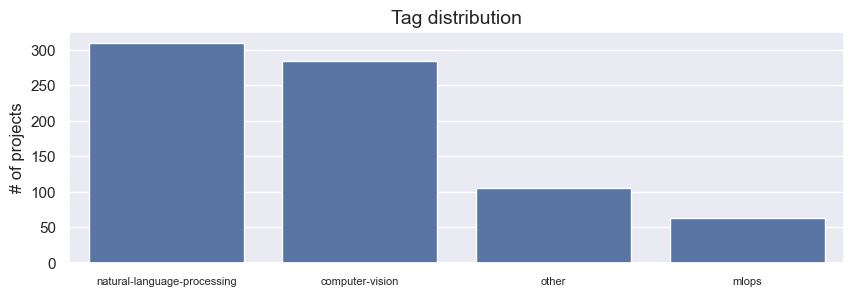

In [15]:
# Plot tag frequencies
tags, tag_counts = zip(*all_tags.most_common())
plt.figure(figsize=(10, 3))
ax = sns.barplot(x=list(tags), y=list(tag_counts))
ax.set_xticklabels(tags, rotation=0, fontsize=8)
plt.title("Tag distribution", fontsize=14)
plt.ylabel("# of projects", fontsize=12)
plt.show()

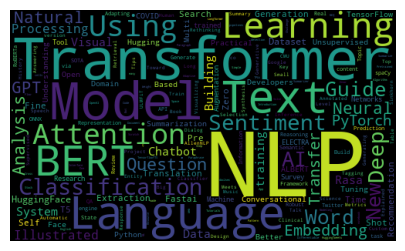

In [16]:
# Most frequent tokens for each tag
tag = "natural-language-processing"
plt.figure(figsize=(10, 3))
subset = df[df.tag == tag]
text = subset.title.values
cloud = WordCloud(
    stopwords=STOPWORDS,
    background_color="black",
    collocations=False,
    width=500,
    height=300,
).generate(" ".join(text))
plt.axis("off")
plt.imshow(cloud)

Looks like the title text feature has some good signal for the respective classes and matches our intuition. We can repeat this for the description text feature as well. This information will become useful when we decide how to use our features for modeling.

##  Data Preprocessing

Preprocessing the data via feature engineering, filtering and cleaning. Certain preprocessing steps are global (don't depend on our dataset, ex. lower casing text, removing stop words, etc.) and others are local (constructs are learned only from the training split, ex. vocabulary, standardization, etc.). For the local, dataset-dependent preprocessing steps, we want to ensure that we split the data first before preprocessing to avoid data leaks.

In [17]:
import json
import re

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

### Feature engineering

We can combine existing input features to create new meaningful signal (helping the model learn).

In [18]:
df["text"] = df.title + " " + df.description
df.head(5)

,id,created_on,title,description,tag,text
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision,Comparison between YOLO and RCNN on real world...
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision,"Show, Infer & Tell: Contextual Inference for C..."
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",other,Awesome Graph Classification A collection of i...
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,other,Awesome Monte Carlo Tree Search A curated list...
4,25,2020-03-07 23:04:31,AttentionWalk,"A PyTorch Implementation of ""Watch Your Step: ...",other,"AttentionWalk A PyTorch Implementation of ""Wat..."


### Cleaning

In [19]:
nltk.download("stopwords")
STOPWORDS = stopwords.words("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/monkey/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
def clean_text(text, stopwords=STOPWORDS):
    """Clean raw text string"""
    # Lower
    text = text.lower()

    # Remove stopwords
    pattern = re.compile(r"\b(" + r"|".join(stopwords) + r")\b\s*")
    text = pattern.sub("", text)

    # Spacing and filters
    text = re.sub(
        r"([!\"'#$%&()*\+,-./:;<=>?@\\\[\]^_`{|}~])", r" \1 ", text
    )  # add spacing
    text = re.sub("[^A-Za-z0-9]+", " ", text)  # remove non alphanumeric chars
    text = re.sub(" +", " ", text)  # remove multiple spaces
    text = text.strip()  # strip white space at the ends
    text = re.sub(r"http\S+", "", text)  #  remove links

    return text

In [21]:
# Apply to dataframe
original_df = df.copy()
df.text = df.text.apply(clean_text)
print(f"{original_df.text.values[0]}\n{df.text.values[0]}")

Comparison between YOLO and RCNN on real world videos Bringing theory to experiment is cool. We can easily train models in colab and find the results in minutes.
comparison yolo rcnn real world videos bringing theory experiment cool easily train models colab find results minutes


In [22]:
# DataFrame cleanup
df = df.drop(
    columns=["id", "created_on", "title", "description"], errors="ignore"
)  # drop cols
df = df.dropna(subset=["tag"])  # drop nulls
df = df[["text", "tag"]]  # rearrange cols
df.head()

,text,tag
0,comparison yolo rcnn real world videos bringin...,computer-vision
1,show infer tell contextual inference creative ...,computer-vision
2,awesome graph classification collection import...,other
3,awesome monte carlo tree search curated list m...,other
4,attentionwalk pytorch implementation watch ste...,other


### Encoding

We need to encode our data into numerical values so that our models can process them. We'll start by encoding our text labels into unique indices.

In [23]:
# Label to index
tags = train_df.tag.unique().tolist()
num_classes = len(tags)
class_to_index = {tag: i for i, tag in enumerate(tags)}
class_to_index

{'mlops': 0,
 'natural-language-processing': 1,
 'computer-vision': 2,
 'other': 3}

In [24]:
# Encode labels
df["tag"] = df["tag"].map(class_to_index)
df.head()

,text,tag
0,comparison yolo rcnn real world videos bringin...,2
1,show infer tell contextual inference creative ...,2
2,awesome graph classification collection import...,3
3,awesome monte carlo tree search curated list m...,3
4,attentionwalk pytorch implementation watch ste...,3


In [25]:
def decode(indices, index_to_class):
    return [index_to_class[index] for index in indices]

In [26]:
index_to_class = {v: k for k, v in class_to_index.items()}
decode(df.head()["tag"].values, index_to_class=index_to_class)

['computer-vision', 'computer-vision', 'other', 'other', 'other']

### Tokenize

Next we'll encode our text as well. Instead of using a random dictionary, we'll use a tokenizer that was used for a pretrained LLM (scibert) to tokenize our text. We'll be fine-tuning this exact model later when we train our model.

In [27]:
import numpy as np
from transformers import BertTokenizer

In [28]:
# Bert tokenizer
tokenizer = BertTokenizer.from_pretrained(
    "allenai/scibert_scivocab_uncased", return_dict=False
)
text = "Transfer learning with transformers for text classification."
encoded_inputs = tokenizer(
    [text], return_tensors="np", padding="longest"
)  # pad to longest item in batch
print("input_ids:", encoded_inputs["input_ids"])
print("attention_mask:", encoded_inputs["attention_mask"])
print(tokenizer.decode(encoded_inputs["input_ids"][0]))

input_ids: [[  102  2268  1904   190 29155   168  3267  2998   205   103]]
attention_mask: [[1 1 1 1 1 1 1 1 1 1]]
[CLS] transfer learning with transformers for text classification. [SEP]


In [29]:
def tokenize(batch):
    tokenizer = BertTokenizer.from_pretrained(
        "allenai/scibert_scivocab_uncased", return_dict=False
    )
    encoded_inputs = tokenizer(
        batch["text"].tolist(), return_tensors="np", padding="longest"
    )
    return dict(
        ids=encoded_inputs["input_ids"],
        masks=encoded_inputs["attention_mask"],
        targets=np.array(batch["tag"]),
    )

In [30]:
# Tokenization
tokenize(df.head(1))

{'ids': array([[  102,  2029,  1778,   609,  6446,  4857,  1332,  2399, 13572,
         19125,  1983,  1954,  6240,  3717,  7434,  1262,   537,   201,
          1040,   545,  4714,   103]]),
 'masks': array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]),
 'targets': array([2])}

We'll combine all of our preprocessing steps into function:

In [31]:
def preprocess(df, class_to_index):
    """Preprocess the data."""
    df["text"] = df.title + " " + df.description  # feature engineering
    df["text"] = df.text.apply(clean_text)  # clean text
    df = df.drop(
        columns=["id", "created_on", "title", "description"], errors="ignore"
    )  # clean dataframe
    df = df[["text", "tag"]]  # rearrange columns
    df["tag"] = df["tag"].map(class_to_index)  # label encoding
    outputs = tokenize(df)
    return outputs

In [32]:
# Apply
preprocess(df=train_df, class_to_index=class_to_index)

{'ids': array([[  102,   856,   532, ...,     0,     0,     0],
        [  102,  2177, 29155, ...,     0,     0,     0],
        [  102,  2180,  3241, ...,     0,     0,     0],
        ...,
        [  102,   453,  2068, ...,  5730,   432,   103],
        [  102, 11268,  1782, ...,     0,     0,     0],
        [  102,  1596,   122, ...,     0,     0,     0]]),
 'masks': array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]),
 'targets': array([0, 1, 1, 1, 1, 2, 1, 2, 3, 1, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 0, 1,
        1, 1, 1, 1, 2, 1, 2, 0, 3, 2, 0, 1, 1, 1, 1, 2, 1, 1, 0, 2, 3, 3,
        3, 0, 2, 1, 3, 3, 1, 1, 1, 1, 2, 1, 2, 2, 2, 3, 2, 1, 1, 3, 1, 0,
        1, 2, 2, 2, 3, 2, 3, 2, 3, 2, 1, 1, 3, 3, 3, 1, 1, 2, 3, 0, 1, 1,
        1, 1, 3, 3, 0, 2, 3, 2, 2, 1, 1, 3, 2, 3, 1, 1, 1, 1, 2, 0, 0, 2,
        1, 1, 2, 2, 1, 1, 0, 3, 1

## Distributed Data Processing

The main issue with our approach above is that we're limited by our single machine in terms how much data our dataframe can hold and that we can preprocess. With the increasing trend in ML for larger unstructured datasets and larger models (LLMs), we can quickly outgrow our single machine constraints and will need to go distributed.

In [33]:
from scripts.data import stratify_split

In [34]:
ray.data.DatasetContext.get_current().execution_options.preserve_order = True

In [35]:
# Data ingestion
ds = ray.data.read_csv(DATASET_LOC)
ds = ds.random_shuffle(seed=1234)
ds.take(1)

2024-12-21 15:25:58,227	INFO dataset.py:2631 -- Tip: Use `take_batch()` instead of `take() / show()` to return records in pandas or numpy batch format.
2024-12-21 15:25:58,234	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-12-21_15-25-50_415018_4417/logs/ray-data
2024-12-21 15:25:58,234	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV] -> AllToAllOperator[RandomShuffle] -> LimitOperator[limit=1]


Running 0: 0.00 row [00:00, ? row/s]

- ReadCSV->SplitBlocks(20) 1: 0.00 row [00:00, ? row/s]

- RandomShuffle 2: 0.00 row [00:00, ? row/s]

Shuffle Map 3:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

Shuffle Reduce 4:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

- limit=1 5: 0.00 row [00:00, ? row/s]

[{'id': 549,
  'created_on': datetime.datetime(2020, 4, 16, 3, 48, 35),
  'title': '15 Best Tools for Tracking Machine Learning Experiments',
  'description': 'A feature comparison of all the open-source and commercial options for experiment tracking.',
  'tag': 'mlops'}]

In [36]:
# Split dataset
test_size = 0.2
train_ds, val_ds = stratify_split(ds, stratify="tag", test_size=test_size)

In [37]:
# Mapping
tags = train_ds.unique(column="tag")
class_to_index = {tag: i for i, tag in enumerate(tags)}

2024-12-21 15:26:00,072	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-12-21_15-25-50_415018_4417/logs/ray-data
2024-12-21 15:26:00,073	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(_add_split)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[Project] -> AllToAllOperator[Aggregate]


Running 0: 0.00 row [00:00, ? row/s]

- ReadCSV->SplitBlocks(20) 1: 0.00 row [00:00, ? row/s]

- RandomShuffle 2: 0.00 row [00:00, ? row/s]

Shuffle Map 3:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

Shuffle Reduce 4:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

- Sort 5: 0.00 row [00:00, ? row/s]

Sort Sample 6:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

Shuffle Map 7:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

Shuffle Reduce 8:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

- MapBatches(_add_split)->MapBatches(_filter_split)->RandomShuffle 9: 0.00 row [00:00, ? row/s]

Shuffle Map 10:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

Shuffle Reduce 11:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

- Project 12: 0.00 row [00:00, ? row/s]

- Aggregate 13: 0.00 row [00:00, ? row/s]

Sort Sample 14:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

Shuffle Map 15:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

Shuffle Reduce 16:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

2024-12-21 15:26:00,160	WARNING progress_bar.py:120 -- Truncating long operator name to 100 characters. To disable this behavior, set `ray.data.DataContext.get_current().DEFAULT_ENABLE_PROGRESS_BAR_NAME_TRUNCATION = False`.


In [38]:
# Distributed preprocessing
sample_ds = train_ds.map_batches(
    preprocess, fn_kwargs={"class_to_index": class_to_index}, batch_format="pandas"
)
sample_ds.show(1)

2024-12-21 15:26:01,901	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-12-21_15-25-50_415018_4417/logs/ray-data
2024-12-21 15:26:01,902	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(_add_split)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)] -> LimitOperator[limit=1]


Running 0: 0.00 row [00:00, ? row/s]

- ReadCSV->SplitBlocks(20) 1: 0.00 row [00:00, ? row/s]

- RandomShuffle 2: 0.00 row [00:00, ? row/s]

Shuffle Map 3:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

Shuffle Reduce 4:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

- Sort 5: 0.00 row [00:00, ? row/s]

Sort Sample 6:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

Shuffle Map 7:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

Shuffle Reduce 8:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

- MapBatches(_add_split)->MapBatches(_filter_split)->RandomShuffle 9: 0.00 row [00:00, ? row/s]

Shuffle Map 10:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

Shuffle Reduce 11:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

- MapBatches(preprocess) 12: 0.00 row [00:00, ? row/s]

- limit=1 13: 0.00 row [00:00, ? row/s]

{'ids': array([  102,  2389, 29477,  3254,  1572,  6773,  4459,  3041,   791,
        2389, 29477,  3350,  2389, 21591,  3254,  7398,  1572,  6773,
        9153,  1098,  5751,  1332,   532,  1186,   103,     0,     0,
           0,     0,     0,     0,     0]), 'masks': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0]), 'targets': 0}


## Training

When developing models, it's always a best practice to start with the simplest models and slowly motivate more complex models. For example our baseline model progression would be:

* random model (predict labels randomly)
* rule-based model (pattern match labels in input text)
* logistic regression (td-idf vectors from text)
* CNN (apply character filters over text)
* Fine-tune LLM (this notebook)

We cover all of these methods in our other lessons but since our focus here in on MLOps, we will skip directly to fine-tuning an LLM for our task.

We'll first set up some functions that will help us achieve complete reproducibility.

### Setup

In [39]:
import os
import random

import torch
from ray.data.preprocessor import Preprocessor

In [40]:
def set_seeds(seed=42):
    """Set seeds for reproducibility."""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    eval("setattr(torch.backends.cudnn, 'deterministic', True)")
    eval("setattr(torch.backends.cudnn, 'benchmark', False)")
    os.environ["PYTHONHASHSEED"] = str(seed)

In [41]:
def load_data(num_samples=None):
    ds = ray.data.read_csv(DATASET_LOC)
    ds = ds.random_shuffle(seed=1234)
    ds = ray.data.from_items(ds.take(num_samples)) if num_samples else ds
    return ds

In [42]:
class CustomPreprocessor:
    """Custom preprocessor class."""

    def __init__(self, class_to_index={}):
        self.class_to_index = class_to_index or {}  # mutable defaults
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}

    def fit(self, ds):
        tags = ds.unique(column="tag")
        self.class_to_index = {tag: i for i, tag in enumerate(tags)}
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        return self

    def transform(self, ds):
        return ds.map_batches(
            preprocess,
            fn_kwargs={"class_to_index": self.class_to_index},
            batch_format="pandas",
        )

## Model

In [43]:
import torch.nn as nn
import torch.nn.functional as F
from transformers import BertModel

In [44]:
# Pretrained LLM
llm = BertModel.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
embedding_dim = llm.config.hidden_size

In [45]:
# Sample
text = "Transfer learning with transformers for text classification."
batch = tokenizer([text], return_tensors="np", padding="longest")
batch = {k: torch.tensor(v) for k, v in batch.items()}  # convert to torch tensors
seq, pool = llm(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
np.shape(seq), np.shape(pool)

(torch.Size([1, 10, 768]), torch.Size([1, 768]))

In [46]:
class FinetunedLLM(nn.Module):
    def __init__(self, llm, dropout_p, embedding_dim, num_classes):
        super(FinetunedLLM, self).__init__()
        self.llm = llm
        self.dropout_p = dropout_p
        self.embedding_dim = embedding_dim
        self.num_classes = num_classes
        self.dropout = torch.nn.Dropout(dropout_p)
        self.fc1 = torch.nn.Linear(embedding_dim, num_classes)

    def forward(self, batch):
        ids, masks = batch["ids"], batch["masks"]
        seq, pool = self.llm(input_ids=ids, attention_mask=masks)
        z = self.dropout(pool)
        z = self.fc1(z)
        return z

    @torch.inference_mode()
    def predict(self, batch):
        self.eval()
        z = self(batch)
        y_pred = torch.argmax(z, dim=1).cpu().numpy()
        return y_pred

    @torch.inference_mode()
    def predict_proba(self, batch):
        self.eval()
        z = self(batch)
        y_probs = F.softmax(z, dim=1).cpu().numpy()
        return y_probs

    def save(self, dp):
        with open(Path(dp, "args.json"), "w") as fp:
            contents = {
                "dropout_p": self.dropout_p,
                "embedding_dim": self.embedding_dim,
                "num_classes": self.num_classes,
            }
            json.dump(contents, fp, indent=4, sort_keys=False)
        torch.save(self.state_dict(), os.path.join(dp, "model.pt"))

    @classmethod
    def load(cls, args_fp, state_dict_fp):
        with open(args_fp, "r") as fp:
            kwargs = json.load(fp=fp)
        llm = BertModel.from_pretrained(
            "allenai/scibert_scivocab_uncased", return_dict=False
        )
        model = cls(llm=llm, **kwargs)
        model.load_state_dict(
            torch.load(state_dict_fp, map_location=torch.device("cpu"))
        )
        return model

In [47]:
# Initialize model
model = FinetunedLLM(
    llm=llm, dropout_p=0.5, embedding_dim=embedding_dim, num_classes=num_classes
)
print(model.named_parameters)

<bound method Module.named_parameters of FinetunedLLM(
  (llm): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31090, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): L

## Batching

We can iterate through our dataset in batches however we may have batches of different sizes. Recall that our tokenizer padded the inputs to the longest item in the batch (padding="longest"). However, our batches for training will be smaller than our large data processing batches and so our batches here may have inputs with different lengths. To address this, we're going to define a custom collate_fn to repad the items in our training batches.

In [48]:
from ray.train.torch import get_device

In [49]:
def pad_array(arr, dtype=np.int32):
    max_len = max(len(row) for row in arr)
    padded_arr = np.zeros((arr.shape[0], max_len), dtype=dtype)
    for i, row in enumerate(arr):
        padded_arr[i][: len(row)] = row
    return padded_arr

In [50]:
def collate_fn(batch):
    batch["ids"] = pad_array(batch["ids"])
    batch["masks"] = pad_array(batch["masks"])
    dtypes = {"ids": torch.int32, "masks": torch.int32, "targets": torch.int64}
    tensor_batch = {}
    for key, array in batch.items():
        tensor_batch[key] = torch.as_tensor(
            array, dtype=dtypes[key], device=get_device()
        )
    return tensor_batch

> pad=(0, max_len) in F.pad refers to (left_padding, right_padding) on the input. There will be no left-padding (hence the 0) and only right-padding. And the constant mode refers to each element being padded to a constant size (size of longest element in the input).

In [51]:
# Sample batch
sample_batch = sample_ds.take_batch(batch_size=128)
collate_fn(batch=sample_batch)

2024-12-21 15:26:08,129	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-12-21_15-25-50_415018_4417/logs/ray-data
2024-12-21 15:26:08,129	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(_add_split)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)] -> LimitOperator[limit=128]


Running 0: 0.00 row [00:00, ? row/s]

- ReadCSV->SplitBlocks(20) 1: 0.00 row [00:00, ? row/s]

- RandomShuffle 2: 0.00 row [00:00, ? row/s]

Shuffle Map 3:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

Shuffle Reduce 4:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

- Sort 5: 0.00 row [00:00, ? row/s]

Sort Sample 6:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

Shuffle Map 7:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

Shuffle Reduce 8:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

- MapBatches(_add_split)->MapBatches(_filter_split)->RandomShuffle 9: 0.00 row [00:00, ? row/s]

Shuffle Map 10:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

Shuffle Reduce 11:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

- MapBatches(preprocess) 12: 0.00 row [00:00, ? row/s]

- limit=128 13: 0.00 row [00:00, ? row/s]

{'ids': tensor([[  102,  3928,   255,  ...,     0,     0,     0],
         [  102,   423,  2647,  ...,     0,     0,     0],
         [  102, 13288,  5923,  ...,     0,     0,     0],
         ...,
         [  102, 13472,  2859,  ...,     0,     0,     0],
         [  102,   502,  1371,  ...,     0,     0,     0],
         [  102,   287,   489,  ...,     0,     0,     0]], dtype=torch.int32),
 'masks': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]], dtype=torch.int32),
 'targets': tensor([0, 0, 0, 0, 3, 0, 0, 2, 1, 1, 2, 3, 0, 0, 3, 2, 2, 3, 0, 2, 3, 0, 0, 2,
         2, 2, 2, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 3, 0, 0, 2, 1, 1, 2, 3, 0, 0, 3,
         2, 2, 3, 0, 2, 3, 0, 0, 2, 2, 2, 2, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 0,
         0, 2, 2, 1, 2, 3, 0, 0, 3, 2, 2, 3, 0, 2, 3, 0, 0, 2, 3, 2, 2, 1, 2, 0,
         2, 2, 

## Utilities

In [ ]:
import tempfile
from pathlib import Path

import ray.train as train
import torch.nn.functional as F
from ray.train import Checkpoint, CheckpointConfig, DataConfig, RunConfig, ScalingConfig
from ray.train.torch import TorchCheckpoint, TorchTrainer
from torch.nn.parallel.distributed import DistributedDataParallel

In [ ]:
def train_step(ds, batch_size, model, num_classes, loss_fn, optimizer):
    """Train step."""
    model.train()
    loss = 0.0
    ds_generator = ds.iter_torch_batches(batch_size=batch_size, collate_fn=collate_fn)
    for i, batch in enumerate(ds_generator):
        optimizer.zero_grad()  # reset gradients
        z = model(batch)  # forward pass
        targets = F.one_hot(
            batch["targets"], num_classes=num_classes
        ).float()  # one-hot (for loss_fn)
        J = loss_fn(z, targets)  # define loss
        J.backward()  # backward pass
        optimizer.step()  # update weights
        loss += (J.detach().item() - loss) / (i + 1)  # cumulative loss
    return loss

> Note: We're using the ray.data.iter_torch_batches method instead of torch.utils.data.DataLoader to create a generator that will yield batches of data. In fact, this is the only line that's different from a typical PyTorch training loop and the actual training workflow remains untouched. Ray supports many other ways to load/consume data for different frameworks as well.

In [ ]:
def eval_step(ds, batch_size, model, num_classes, loss_fn):
    """Eval step."""
    model.eval()
    loss = 0.0
    y_trues, y_preds = [], []
    ds_generator = ds.iter_torch_batches(batch_size=batch_size, collate_fn=collate_fn)
    with torch.inference_mode():
        for i, batch in enumerate(ds_generator):
            z = model(batch)
            targets = F.one_hot(
                batch["targets"], num_classes=num_classes
            ).float()  # one-hot (for loss_fn)
            J = loss_fn(z, targets).item()
            loss += (J - loss) / (i + 1)
            y_trues.extend(batch["targets"].cpu().numpy())
            y_preds.extend(torch.argmax(z, dim=1).cpu().numpy())
    return loss, np.vstack(y_trues), np.vstack(y_preds)

Next, we'll define the train_loop_per_worker which defines the overall training loop for each worker. It's important that we include operations like loading the datasets, models, etc. so that each worker will have its own copy of these objects. Ray takes care of combining all the workers' results at the end of each iteration, so from the user's perspective, it's the exact same as training on a single machine!

The only additional lines of code we need to add compared to a typical PyTorch training loop are the following:

session.get_dataset_shard("train") and session.get_dataset_shard("val") to load the data splits (session.get_dataset_shard).
model = train.torch.prepare_model(model) to prepare the torch model for distributed execution (train.torch.prepare_model).
batch_size_per_worker = batch_size // session.get_world_size() to adjust the batch size for each worker (session.get_world_size).
session.report(metrics, checkpoint=checkpoint) to report metrics and save our model checkpoint (session.report).
All the other lines of code are the same as a typical PyTorch training loop!

In [ ]:
# Training loop


def train_loop_per_worker(config):
    # Hyperparameters
    dropout_p = config["dropout_p"]
    lr = config["lr"]
    lr_factor = config["lr_factor"]
    lr_patience = config["lr_patience"]
    num_epochs = config["num_epochs"]
    batch_size = config["batch_size"]
    num_classes = config["num_classes"]

    # Get datasets
    set_seeds()
    train_ds = train.get_dataset_shard("train")
    val_ds = train.get_dataset_shard("val")

    # Model
    llm = BertModel.from_pretrained(
        "allenai/scibert_scivocab_uncased", return_dict=False
    )
    model = FinetunedLLM(
        llm=llm,
        dropout_p=dropout_p,
        embedding_dim=llm.config.hidden_size,
        num_classes=num_classes,
    )
    model = train.torch.prepare_model(model)

    # Training components
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=lr_factor, patience=lr_patience
    )

    # Training
    num_workers = train.get_context().get_world_size()
    batch_size_per_worker = batch_size // num_workers
    for epoch in range(num_epochs):
        # Step
        train_loss = train_step(
            train_ds, batch_size_per_worker, model, num_classes, loss_fn, optimizer
        )
        val_loss, _, _ = eval_step(
            val_ds, batch_size_per_worker, model, num_classes, loss_fn
        )
        scheduler.step(val_loss)

        # Checkpoint
        with tempfile.TemporaryDirectory() as dp:
            if isinstance(model, DistributedDataParallel):  # cpu
                model.module.save(dp=dp)
            else:
                model.save(dp=dp)
            metrics = dict(
                epoch=epoch,
                lr=optimizer.param_groups[0]["lr"],
                train_loss=train_loss,
                val_loss=val_loss,
            )
            checkpoint = Checkpoint.from_directory(dp)
            train.report(metrics, checkpoint=checkpoint)

Our dataset doesn't suffer from horrible class imbalance, but if it did, we could easily account for it through our loss function. There are also other strategies such as over-sampling less frequent classes and under-sampling popular classes.

```python
# Class weights
batch_counts = []
for batch in train_ds.iter_torch_batches(batch_size=256, collate_fn=collate_fn):
    batch_counts.append(np.bincount(batch["targets"].cpu().numpy()))
counts = [sum(count) for count in zip(*batch_counts)]
class_weights = np.array([1.0 / count for i, count in enumerate(counts)])
class_weights_tensor = torch.Tensor(class_weights).to(get_device())

# Training components
loss_fn = nn.BCEWithLogitsLoss(weight=class_weights_tensor)
...
```

## Configurations

In [ ]:
from scripts.config import EFS_DIR

In [ ]:
# Train loop config
train_loop_config = {
    "dropout_p": 0.5,
    "lr": 1e-4,
    "lr_factor": 0.8,
    "lr_patience": 3,
    "num_epochs": 10,
    "batch_size": 256,
    "num_classes": num_classes,
}

In [ ]:
# Scaling config
scaling_config = ScalingConfig(
    num_workers=num_workers,
    use_gpu=bool(resources_per_worker["GPU"]),
    resources_per_worker=resources_per_worker,
)

In [ ]:
# Run config
checkpoint_config = CheckpointConfig(
    num_to_keep=1, checkpoint_score_attribute="val_loss", checkpoint_score_order="min"
)
run_config = RunConfig(
    name="llm", checkpoint_config=checkpoint_config, storage_path=EFS_DIR
)

## Training

In [ ]:
# Dataset
ds = load_data()
train_ds, val_ds = stratify_split(ds, stratify="tag", test_size=test_size)

In [ ]:
# Preprocess
preprocessor = CustomPreprocessor()
preprocessor = preprocessor.fit(train_ds)
train_ds = preprocessor.transform(train_ds)
val_ds = preprocessor.transform(val_ds)
train_ds = train_ds.materialize()
val_ds = val_ds.materialize()

In [ ]:
# Dataset config
options = ray.data.ExecutionOptions(preserve_order=True)
dataset_config = DataConfig(datasets_to_split=["train"], execution_options=options)

In [ ]:
# Trainer
trainer = TorchTrainer(
    train_loop_per_worker=train_loop_per_worker,
    train_loop_config=train_loop_config,
    scaling_config=scaling_config,
    run_config=run_config,
    datasets={"train": train_ds, "val": val_ds},
    dataset_config=dataset_config,
    metadata={"class_to_index": preprocessor.class_to_index},
)

In [ ]:
%%time
# Train
results = trainer.fit()

In [ ]:
# Metrics per epoch
results.metrics_dataframe

In [ ]:
# Best checkpoints
results.best_checkpoints

## Observability

While our model is training, we can inspect our Ray dashboard to observe how our compute resources are being utilized.

We can inspect our Ray dashboard by opening http://127.0.0.1:8265 on a browser window. Click on Cluster on the top menu bar and then we will be able to see a list of our nodes (head and worker) and their utilizations.

## Evaluation

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
class TorchPredictor:
    def __init__(self, preprocessor, model):
        self.preprocessor = preprocessor
        self.model = model
        self.model.eval()

    def __call__(self, batch):
        results = self.model.predict(collate_fn(batch))
        return {"output": results}

    def predict_proba(self, batch):
        results = self.model.predict_proba(collate_fn(batch))
        return {"output": results}

    def get_preprocessor(self):
        return self.preprocessor

    @classmethod
    def from_checkpoint(cls, checkpoint):
        metadata = checkpoint.get_metadata()
        preprocessor = CustomPreprocessor(class_to_index=metadata["class_to_index"])
        model = FinetunedLLM.load(
            Path(checkpoint.path, "args.json"), Path(checkpoint.path, "model.pt")
        )
        return cls(preprocessor=preprocessor, model=model)

In [ ]:
# Artifacts
best_checkpoint = results.best_checkpoints[0][0]
predictor = TorchPredictor.from_checkpoint(best_checkpoint)
preprocessor = predictor.get_preprocessor()

In [ ]:
# Test (holdout) dataset
HOLDOUT_LOC = "../datasets/holdout.csv"
test_ds = ray.data.read_csv(HOLDOUT_LOC)
preprocessed_ds = preprocessor.transform(test_ds)
preprocessed_ds.take(1)

In [ ]:
# y_true
values = preprocessed_ds.select_columns(cols=["targets"]).take_all()
y_true = np.stack([item["targets"] for item in values])
print(y_true)

In [ ]:
# y_pred
predictions = preprocessed_ds.map_batches(predictor).take_all()
y_pred = np.array([d["output"] for d in predictions])

In [ ]:
# Evaluate
metrics = precision_recall_fscore_support(y_true, y_pred, average="weighted")
{"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}

In [ ]:
def evaluate(ds, predictor):
    # y_true
    preprocessor = predictor.get_preprocessor()
    preprocessed_ds = preprocessor.transform(ds)
    values = preprocessed_ds.select_columns(cols=["targets"]).take_all()
    y_true = np.stack([item["targets"] for item in values])

    # y_pred
    predictions = preprocessed_ds.map_batches(predictor).take_all()
    y_pred = np.array([d["output"] for d in predictions])

    # Evaluate
    metrics = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
    return performance

In [ ]:
# Evaluate on test split
performance = evaluate(ds=test_ds, predictor=predictor)
print(json.dumps(performance, indent=2))

## Inference

In [ ]:
import pandas as pd

In [ ]:
def format_prob(prob, index_to_class):
    d = {}
    for i, item in enumerate(prob):
        d[index_to_class[i]] = item
    return d

In [ ]:
def predict_proba(ds, predictor):
    preprocessor = predictor.get_preprocessor()
    preprocessed_ds = preprocessor.transform(ds)
    outputs = preprocessed_ds.map_batches(predictor.predict_proba)

    # Convert the output to a serializable array
    y_prob = np.array([d["output"] for d in outputs.take_all()])

    results = []
    for i, prob in enumerate(y_prob):
        # Convert probabilities to Python-native types
        prob = prob.astype(float)  # Ensure all elements are Python float

        tag = preprocessor.index_to_class[prob.argmax()]

        results.append(
            {
                "prediction": tag,
                "probabilities": format_prob(prob, preprocessor.index_to_class),
            }
        )
    return results

In [ ]:
# Predict on sample
title = "Transfer learning with transformers"
description = "Using transformers for transfer learning on text classification tasks."
sample_ds = ray.data.from_items(
    [{"title": title, "description": description, "tag": "other"}]
)
predict_proba(ds=sample_ds, predictor=predictor)

## Optimization

Distributed training strategies are great for when our data or models are too large for training but there are additional strategies to make the models itself smaller for serving. The following model compression techniques are commonly used to reduce the size of the model:

* [Pruning](https://pytorch.org/tutorials/intermediate/pruning_tutorial.html): remove weights (unstructured) or entire channels (structured) to reduce the size of the network. The objective is to preserve the model’s performance while increasing its sparsity.
* [Quantization](https://pytorch.org/docs/stable/quantization.html): reduce the memory footprint of the weights by reducing their precision (ex. 32 bit to 8 bit). We may loose some precision but it shouldn’t affect performance too much.
* [Distillation](https://pytorch.org/tutorials/beginner/knowledge_distillation_tutorial.html): training smaller networks to “mimic” larger networks by having it reproduce the larger network’s layers’ outputs.

## Experiment tracking

So far, we've been training our models but we don't have a way to more deeply track and compare them. We'll achieve this but defining a proper process for experiment tracking which we'll use for all future experiments (including hyperparameter optimization). Experiment tracking is the processing of managing all the different experiments and their components, such as parameters, metrics, models and other artifacts and it enables us to:

Organize all the necessary components of a specific experiment. It's important to have everything in one place and know where it is so you can use them later.
Reproduce past results (easily) using saved experiments.
Log iterative improvements across time, data, ideas, teams, etc.
There are many options for experiment tracking but we're going to use MLflow (100% free and open-source) because it has all the functionality we'll need (and growing integration support). There are also several popular options such as a Comet ML (Used by Google AI, HuggingFace, etc.) and Weights and Biases (Used by Open AI, Toyota Research, etc.). These are fantastic options if you want a fully managed experiment tracking solution.

### Setup

In [ ]:
import time
from pathlib import Path

import mlflow
from ray.tune.logger.mlflow import MLflowLoggerCallback

In [ ]:
# Config MLflow
MODEL_REGISTRY = Path(f"{EFS_DIR}/mlflow")
Path(MODEL_REGISTRY).mkdir(parents=True, exist_ok=True)
MLFLOW_TRACKING_URI = "file://" + str(MODEL_REGISTRY.absolute())
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
print(mlflow.get_tracking_uri())

### Integration

In [ ]:
# MLflow callback
experiment_name = f"llm-{int(time.time())}"
mlflow_callback = MLflowLoggerCallback(
    tracking_uri=MLFLOW_TRACKING_URI,
    experiment_name=experiment_name,
    save_artifact=True,
)

In [ ]:
# Run configuration with MLflow callback
run_config = RunConfig(
    callbacks=[mlflow_callback],
    checkpoint_config=checkpoint_config,
    storage_path=EFS_DIR,
)

### Training

In [ ]:
# Dataset
ds = load_data()
train_ds, val_ds = stratify_split(ds, stratify="tag", test_size=test_size)

In [ ]:
# Preprocess
preprocessor = CustomPreprocessor()
preprocessor = preprocessor.fit(train_ds)
train_ds = preprocessor.transform(train_ds)
val_ds = preprocessor.transform(val_ds)
train_ds = train_ds.materialize()
val_ds = val_ds.materialize()

In [ ]:
# Trainer
trainer = TorchTrainer(
    train_loop_per_worker=train_loop_per_worker,
    train_loop_config=train_loop_config,
    scaling_config=scaling_config,
    run_config=run_config,  # uses RunConfig with MLflow callback
    datasets={"train": train_ds, "val": val_ds},
    dataset_config=dataset_config,
    metadata={"class_to_index": preprocessor.class_to_index},
)

In [ ]:
%%time
# Train
results = trainer.fit()

In [ ]:
results.metrics_dataframe

In [ ]:
# Sorted runs
sorted_runs = mlflow.search_runs(
    experiment_names=[experiment_name], order_by=["metrics.val_loss ASC"]
)
sorted_runs

In [ ]:
# Best run
best_run = sorted_runs.iloc[0]
best_run

### Dashboard

Let's view what we've tracked from our experiment. MLFlow serves a dashboard for us to view and explore our experiments on a localhost port:
`mlflow server -h 0.0.0.0 -p 8080 --backend-store-uri $EFS_DIR/mlflow`

MLFlow creates a main dashboard with all your experiments and their respective runs. We can sort runs by clicking on the column headers.

### Loading

In [ ]:
from urllib.parse import urlparse

from ray.train import Result

In [ ]:
def get_best_checkpoint(run_id):
    artifact_dir = urlparse(
        mlflow.get_run(run_id).info.artifact_uri
    ).path  # get path from mlflow
    results = Result.from_path(artifact_dir)
    return results.best_checkpoints[0][0]

In [ ]:
print(results.best_checkpoints)

In [ ]:
# Artifacts
# best_checkpoint = get_best_checkpoint(run_id=best_run.run_id)
predictor = TorchPredictor.from_checkpoint(results.best_checkpoints[0][0])
preprocessor = predictor.get_preprocessor()

In [ ]:
# Evaluate on test split
performance = evaluate(ds=test_ds, predictor=predictor)
print(json.dumps(performance, indent=2))

In [ ]:
# Predict on sample
title = "Transfer learning with transformers"
description = "Using transformers for transfer learning on text classification tasks."
sample_ds = ray.data.from_items(
    [{"title": title, "description": description, "tag": "other"}]
)
predict_proba(ds=sample_ds, predictor=predictor)

##  Hyperparameter tuning

In [ ]:
from ray import tune
from ray.tune import Tuner
from ray.tune.schedulers import AsyncHyperBandScheduler
from ray.tune.search import ConcurrencyLimiter
from ray.tune.search.hyperopt import HyperOptSearch

In [ ]:
# Number of trials (small sample)
num_runs = 2

In [ ]:
# Set up
set_seeds()

In [ ]:
# Dataset
ds = load_data()
train_ds, val_ds = stratify_split(ds, stratify="tag", test_size=test_size)

In [ ]:
# Preprocess
preprocessor = CustomPreprocessor()
preprocessor = preprocessor.fit(train_ds)
train_ds = preprocessor.transform(train_ds)
val_ds = preprocessor.transform(val_ds)
train_ds = train_ds.materialize()
val_ds = val_ds.materialize()

In [ ]:
# Trainer
trainer = TorchTrainer(
    train_loop_per_worker=train_loop_per_worker,
    train_loop_config=train_loop_config,
    scaling_config=scaling_config,
    datasets={"train": train_ds, "val": val_ds},
    dataset_config=dataset_config,
    metadata={"class_to_index": preprocessor.class_to_index},
)

In [ ]:
# MLflow callback
mlflow_callback = MLflowLoggerCallback(
    tracking_uri=MLFLOW_TRACKING_URI,
    experiment_name=experiment_name,
    save_artifact=True,
)

In [ ]:
# Run configuration
checkpoint_config = CheckpointConfig(
    num_to_keep=1, checkpoint_score_attribute="val_loss", checkpoint_score_order="min"
)
run_config = RunConfig(
    callbacks=[mlflow_callback],
    checkpoint_config=checkpoint_config,
    storage_path=EFS_DIR,
)

In [ ]:
# Hyperparameters to start with
initial_params = [
    {
        "train_loop_config": {
            "dropout_p": 0.5,
            "lr": 1e-4,
            "lr_factor": 0.8,
            "lr_patience": 3,
        }
    }
]
search_alg = HyperOptSearch(points_to_evaluate=initial_params)
search_alg = ConcurrencyLimiter(
    search_alg, max_concurrent=2
)  # trade off b/w optimization and search space

In [ ]:
# Parameter space
param_space = {
    "train_loop_config": {
        "dropout_p": tune.uniform(0.3, 0.9),
        "lr": tune.loguniform(1e-5, 5e-4),
        "lr_factor": tune.uniform(0.1, 0.9),
        "lr_patience": tune.uniform(1, 10),
    }
}

In [ ]:
# Scheduler
scheduler = AsyncHyperBandScheduler(
    max_t=train_loop_config["num_epochs"],  # max epoch (<time_attr>) per trial
    grace_period=5,  # min epoch (<time_attr>) per trial
)

In [ ]:
# Tune config
tune_config = tune.TuneConfig(
    metric="val_loss",
    mode="min",
    search_alg=search_alg,
    scheduler=scheduler,
    num_samples=num_runs,
)

In [ ]:
# Tuner
tuner = Tuner(
    trainable=trainer,
    run_config=run_config,
    param_space=param_space,
    tune_config=tune_config,
)

In [ ]:
%%time
# Tune
results = tuner.fit()

In [ ]:
# All trials in experiment
results.get_dataframe()

In [ ]:
# Best trial's epochs
best_trial = results.get_best_result(metric="val_loss", mode="min")
best_trial.metrics_dataframe

In [ ]:
# Best trial's hyperparameters
best_trial.config["train_loop_config"]

In [ ]:
# Sorted runs
sorted_runs = mlflow.search_runs(
    experiment_names=[experiment_name], order_by=["metrics.val_loss ASC"]
)
sorted_runs

In [ ]:
# Artifacts
# best_checkpoint = get_best_checkpoint(run_id=best_run.run_id)
predictor = TorchPredictor.from_checkpoint(
    results.get_best_result(metric="val_loss", mode="min").best_checkpoints[0][0]
)
preprocessor = predictor.get_preprocessor()

In [ ]:
# Evaluate on test split
performance = evaluate(ds=test_ds, predictor=predictor)
print(json.dumps(performance, indent=2))

In [ ]:
# Predict on sample
title = "Transfer learning with transformers"
description = "Using transformers for transfer learning on text classification tasks."
sample_ds = ray.data.from_items(
    [{"title": title, "description": description, "tag": "other"}]
)
predict_proba(ds=sample_ds, predictor=predictor)

## Evaluation

So far we've been evaluating our models by determing the overall precision, recall and f1 scores. But since performance is one of the key decision making factors when comparing different models, we should have even more nuanced evaluation strategies.
* Coarse-grained metrics
* Fine-grained metrics
* Confusion matrix
* Confidence learning
* Slice metrics

In [ ]:
# Metrics
metrics = {"overall": {}, "class": {}}

In [ ]:
# Artifacts
predictor = TorchPredictor.from_checkpoint(best_checkpoint)
preprocessor = predictor.get_preprocessor()

In [ ]:
# y_test
preprocessed_ds = preprocessor.transform(test_ds)
values = preprocessed_ds.select_columns(cols=["targets"]).take_all()
y_test = np.stack([item["targets"] for item in values])

In [ ]:
# y_prob
outputs = preprocessed_ds.map_batches(predictor.predict_proba)
y_prob = np.array([d["output"] for d in outputs.take_all()])

In [ ]:
# y_prob
print(np.shape(y_test))
print(np.shape(y_prob))

In [ ]:
# Add columns (for convenience)
test_df = test_ds.to_pandas()
test_df["text"] = test_df["title"] + " " + test_df["description"]
test_df["prediction"] = test_df.index.map(
    lambda i: preprocessor.index_to_class[y_pred[i]]
)
test_df.head()

### Coarse-grained metrics

While we were developing our models, our evaluation process involved computing the coarse-grained metrics such as overall precision, recall and f1 metrics.
* True positives (TP): we correctly predicted class X.
* False positives (FP): we incorrectly predicted class X but it was another class.
* True negatives (TN): we correctly predicted that it's wasn't the class X.
* False negatives (FN): we incorrectly predicted that it wasn't the class X but it was.

<math xmlns="http://www.w3.org/1998/Math/MathML" display="block">
  <mtext>precision</mtext>
  <mo>=</mo>
  <mfrac>
    <mrow>
      <mi>T</mi>
      <mi>P</mi>
    </mrow>
    <mrow>
      <mi>T</mi>
      <mi>P</mi>
      <mo>+</mo>
      <mi>F</mi>
      <mi>P</mi>
    </mrow>
  </mfrac>
</math>
<br>
<math xmlns="http://www.w3.org/1998/Math/MathML" display="block">
  <mtext>recall</mtext>
  <mo>=</mo>
  <mfrac>
    <mrow>
      <mi>T</mi>
      <mi>P</mi>
    </mrow>
    <mrow>
      <mi>T</mi>
      <mi>P</mi>
      <mo>+</mo>
      <mi>F</mi>
      <mi>N</mi>
    </mrow>
  </mfrac>
</math>
<br>
<math xmlns="http://www.w3.org/1998/Math/MathML" display="block">
  <mtext>f1</mtext>
  <mo>=</mo>
  <mfrac>
    <mrow>
      <mn>2</mn>
      <mo>&#x2217;</mo>
      <mi>p</mi>
      <mi>r</mi>
      <mi>e</mi>
      <mi>c</mi>
      <mi>i</mi>
      <mi>s</mi>
      <mi>i</mi>
      <mi>o</mi>
      <mi>n</mi>
      <mo>&#x2217;</mo>
      <mi>r</mi>
      <mi>e</mi>
      <mi>c</mi>
      <mi>a</mi>
      <mi>l</mi>
      <mi>l</mi>
    </mrow>
    <mrow>
      <mi>p</mi>
      <mi>r</mi>
      <mi>e</mi>
      <mi>c</mi>
      <mi>i</mi>
      <mi>s</mi>
      <mi>i</mi>
      <mi>o</mi>
      <mi>n</mi>
      <mo>+</mo>
      <mi>r</mi>
      <mi>e</mi>
      <mi>c</mi>
      <mi>a</mi>
      <mi>l</mi>
      <mi>l</mi>
    </mrow>
  </mfrac>
</math>

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
# Overall metrics
overall_metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
metrics["overall"]["precision"] = overall_metrics[0]
metrics["overall"]["recall"] = overall_metrics[1]
metrics["overall"]["f1"] = overall_metrics[2]
metrics["overall"]["num_samples"] = np.float64(len(y_test))
print(json.dumps(metrics["overall"], indent=4))

### Fine-grained metrics

In [ ]:
from collections import OrderedDict

In [ ]:
# Per-class metrics
class_metrics = precision_recall_fscore_support(y_test, y_pred, average=None)
for i, _class in enumerate(preprocessor.class_to_index):
    metrics["class"][_class] = {
        "precision": class_metrics[0][i],
        "recall": class_metrics[1][i],
        "f1": class_metrics[2][i],
        "num_samples": np.float64(class_metrics[3][i]),
    }

In [ ]:
# Metrics for a specific class
tag = "natural-language-processing"
print(json.dumps(metrics["class"][tag], indent=2))

In [ ]:
# Sorted tags
sorted_tags_by_f1 = OrderedDict(
    sorted(metrics["class"].items(), key=lambda tag: tag[1]["f1"], reverse=True)
)
for item in sorted_tags_by_f1.items():
    print(json.dumps(item, indent=2))

### Confusion matrix

* True positives (TP): learn about where our model performs well.
* False positives (FP): potentially identify samples which may need to be relabeled.
* False negatives (FN): identify the model's less performant areas to oversample later.

> It's a good to have our FP/FN samples feed back into our annotation pipelines in the event we want to fix their labels and have those changes be reflected everywhere.

In [ ]:
# TP, FP, FN samples
tag = "natural-language-processing"
index = preprocessor.class_to_index[tag]
tp, fp, fn = [], [], []
for i, true in enumerate(y_test):
    pred = y_pred[i]
    if index == true == pred:
        tp.append(i)
    elif index != true and index == pred:
        fp.append(i)
    elif index == true and index != pred:
        fn.append(i)

In [ ]:
print(tp)
print(fp)
print(fn)

In [ ]:
# Samples
num_samples = 3
cm = [(tp, "True positives"), (fp, "False positives"), (fn, "False negatives")]
for item in cm:
    if len(item[0]):
        print(f"\n=== {item[1]} ===")
        for index in item[0][:num_samples]:
            print(f"{test_df.iloc[index].text}")
            print(f"    true: {test_df.tag[index]}")
            print(f"    pred: {test_df.prediction[index]}\n")

## Confidence learning

While the confusion-matrix sample analysis was a coarse-grained process, we can also use fine-grained confidence based approaches to identify potentially mislabeled samples. Here we’re going to focus on the specific labeling quality as opposed to the final model predictions.

Simple confidence based techniques include identifying samples whose:

**Categorical**
* prediction is incorrect (also indicate TN, FP, FN)
* confidence score for the correct class is below a threshold
* confidence score for an incorrect class is above a threshold
* standard deviation of confidence scores over top N samples is low
* different predictions from same model using different parameters

**Continuous**
* difference between predicted and ground-truth values is above some %

> The operations in this section can be applied to entire labeled dataset to discover labeling errors via confidence learning.

In [ ]:
# Tag to inspect
tag = "natural-language-processing"
index = class_to_index[tag]
indices = np.where(y_test == index)[0]

In [ ]:
# Confidence score for the correct class is below a threshold
low_confidence = []
min_threshold = 0.5
for i in indices:
    prob = y_prob[i][index]
    if prob <= 0.5:
        low_confidence.append(
            {
                "text": f"{test_df.iloc[i].text}",
                "true": test_df.tag[i],
                "pred": test_df.prediction[i],
                "prob": prob,
            }
        )

In [ ]:
low_confidence[0:3]

In [ ]:
import cleanlab
from cleanlab.filter import find_label_issues

In [ ]:
# Find label issues
label_issues = find_label_issues(
    labels=y_test, pred_probs=y_prob, return_indices_ranked_by="self_confidence"
)
test_df.iloc[label_issues].drop(columns=["text"]).head()

### Slice metrics

Just inspecting the overall and class metrics isn't enough to deploy our new version to production. There may be key slices of our dataset that we need to do really well on:
* Target / predicted classes (+ combinations)
* Features (explicit and implicit)
* Metadata (timestamps, sources, etc.)
* Priority slices / experience (minority groups, large customers, etc.)

An easy way to create and evaluate slices is to define slicing functions.

In [ ]:
from snorkel.slicing import PandasSFApplier, slice_dataframe, slicing_function

In [ ]:
@slicing_function()
def nlp_llm(x):
    """NLP projects that use LLMs."""
    nlp_project = "natural-language-processing" in x.tag
    llm_terms = ["transformer", "llm", "bert"]
    llm_project = any(s.lower() in x.text.lower() for s in llm_terms)
    return nlp_project and llm_project

In [ ]:
@slicing_function()
def short_text(x):
    """Projects with short titles and descriptions."""
    return len(x.text.split()) < 8  # less than 8 words

Here we're using Snorkel's slicing_function to create our different slices. We can visualize our slices by applying this slicing function to a relevant DataFrame using slice_dataframe.

In [ ]:
nlp_llm_df = slice_dataframe(test_df, nlp_llm)
nlp_llm_df[["text", "tag"]].head()

In [ ]:
short_text_df = slice_dataframe(test_df, short_text)
short_text_df[["text", "tag"]].head()

We can define even more slicing functions and create a slices record array using the PandasSFApplier. The slices array has N (# of data points) items and each item has S (# of slicing functions) items, indicating whether that data point is part of that slice. Think of this record array as a masking layer for each slicing function on our data.

In [ ]:
# Slices
slicing_functions = [nlp_llm, short_text]
applier = PandasSFApplier(slicing_functions)
slices = applier.apply(test_df)
slices

In [ ]:
# Score slices
metrics["slices"] = {}
for slice_name in slices.dtype.names:
    mask = slices[slice_name].astype(bool)
    if sum(mask):
        slice_metrics = precision_recall_fscore_support(
            y_test[mask], y_pred[mask], average="micro"
        )
        metrics["slices"][slice_name] = {}
        metrics["slices"][slice_name]["precision"] = slice_metrics[0]
        metrics["slices"][slice_name]["recall"] = slice_metrics[1]
        metrics["slices"][slice_name]["f1"] = slice_metrics[2]
        metrics["slices"][slice_name]["num_samples"] = len(y_test[mask])

In [ ]:
print(json.dumps(metrics["slices"], indent=2))

## Interpretability

Besides just comparing predicted outputs with ground truth values, we can also inspect the inputs to our models. What aspects of the input are more influential towards the prediction? If the focus is not on the relevant features of our input, then we need to explore if there is a hidden pattern we're missing or if our model has learned to overfit on the incorrect features. We can use techniques such as SHAP (SHapley Additive exPlanations) or LIME (Local Interpretable Model-agnostic Explanations) to inspect feature importance. On a high level, these techniques learn which features have the most signal by assessing the performance in their absence. These inspections can be performed on a global level (ex. per-class) or on a local level (ex. single prediction).

In [ ]:
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline

LimeTextExplainer.explain_instance function requires a classifier_fn that takes in a list of strings and outputs the predicted probabilities.

In [ ]:
def classifier_fn(texts):
    ds = ray.data.from_items(
        [{"title": text, "description": "", "tag": "other"} for text in texts]
    )
    preprocessed_ds = preprocessor.transform(ds)
    outputs = preprocessed_ds.map_batches(predictor.predict_proba)
    y_prob = np.array([d["output"] for d in outputs.take_all()])
    return y_prob

In [ ]:
# Explain instance
text = "Using pretrained convolutional neural networks for object detection."
explainer = LimeTextExplainer(class_names=list(class_to_index.keys()))
explainer.explain_instance(
    text, classifier_fn=classifier_fn, top_labels=1
).show_in_notebook(text=True)

## Behavioral testing

Besides just looking at metrics, we also want to conduct some behavioral sanity tests. Behavioral testing is the process of testing input data and expected outputs while treating the model as a black box. They don't necessarily have to be adversarial in nature but more along the types of perturbations we'll see in the real world once our model is deployed. A landmark paper on this topic is Beyond Accuracy: Behavioral Testing of NLP Models with CheckList which breaks down behavioral testing into three types of tests:

* `invariance`: Changes should not affect outputs.

In [ ]:
# Invariance via verb injection (changes should not affect outputs)
tokens = ["revolutionized", "disrupted"]
texts = [f"Transformers applied to NLP have {token} the ML field." for token in tokens]
[preprocessor.index_to_class[y_prob.argmax()] for y_prob in classifier_fn(texts=texts)]

* `directional`: Change should affect outputs.

In [ ]:
# Directional expectations (changes with known outputs)
tokens = ["text classification", "image classification"]
texts = [f"ML applied to {token}." for token in tokens]
[preprocessor.index_to_class[y_prob.argmax()] for y_prob in classifier_fn(texts=texts)]

* `minimum functionality`: Simple combination of inputs and expected outputs.

In [ ]:
# Minimum Functionality Tests (simple input/output pairs)
tokens = ["natural language processing", "mlops"]
texts = [f"{token} is the next big wave in machine learning." for token in tokens]
[preprocessor.index_to_class[y_prob.argmax()] for y_prob in classifier_fn(texts=texts)]

## Online evaluation

Once we've evaluated our model's ability to perform on a static dataset we can run several types of online evaluation techniques to determine performance on actual production data. It can be performed using labels or, in the event we don't readily have labels, proxy signals.
* manually label a subset of incoming data to evaluate periodically.
* asking the initial set of users viewing a newly categorized content if it's correctly classified.
* allow users to report misclassified content by our model.


## AB tests

AB testing involves sending production traffic to our current system (control group) and the new version (treatment group) and measuring if there is a statistical difference between the values for two metrics. There are several common issues with AB testing such as accounting for different sources of bias, such as the novelty effect of showing some users the new system. We also need to ensure that the same users continue to interact with the same systems so we can compare the results without contamination.
![title](img/ab.png)

## Canary tests

Canary tests involve sending most of the production traffic to the currently deployed system but sending traffic from a small cohort of users to the new system we're trying to evaluate. Again we need to make sure that the same users continue to interact with the same system as we gradually roll out the new system.
![title](img/canary.png)


## Shadow tests

Shadow testing involves sending the same production traffic to the different systems. We don't have to worry about system contamination and it's very safe compared to the previous approaches since the new system's results are not served. However, we do need to ensure that we're replicating as much of the production system as possible so we can catch issues that are unique to production early on. But overall, shadow testing is easy to monitor, validate operational consistency, etc.
![title](img/shadow.png)

## Capability vs. alignment

We've seen the many different metrics that we'll want to calculate when it comes to evaluating our model but not all metrics mean the same thing. And this becomes very important when it comes to choosing the "best" model(s).

- **capability**: the ability of our model to perform a task, measured by the objective function we optimize for (ex. log loss)
- **alignment**: desired behavior of our model, measured by metrics that are not differentiable or don't account for misclassifications and probability differences (ex. accuracy, precision, recall, etc.)

While capability (ex. loss) and alignment (ex. accuracy) metrics may seem to be aligned, their differences can indicate issues in our data:

- ↓ accuracy, ↑ loss = large errors on lots of data (worst case)
- ↓ accuracy, ↓ loss = small errors on lots of data, distributions are close but tipped towards misclassifications (misaligned)
- ↑ accuracy, ↑ loss = large errors on some data (incorrect predictions have very skewed distributions)
- ↑ accuracy, ↓ loss = no/few errors on some data (best case)

## Serving

In [216]:
from scripts.config import EFS_DIR

In [217]:
# Train loop config
train_loop_config = {
    "dropout_p": 0.5,
    "lr": 1e-4,
    "lr_factor": 0.8,
    "lr_patience": 3,
    "num_epochs": 10,
    "batch_size": 256,
    "num_classes": num_classes,
}

In [218]:
# Scaling config
scaling_config = ScalingConfig(
    num_workers=num_workers,
    use_gpu=bool(resources_per_worker["GPU"]),
    resources_per_worker=resources_per_worker,
)

In [219]:
# Run config
checkpoint_config = CheckpointConfig(
    num_to_keep=1, checkpoint_score_attribute="val_loss", checkpoint_score_order="min"
)
run_config = RunConfig(
    name="llm", checkpoint_config=checkpoint_config, storage_path=EFS_DIR
)

In [209]:
# Dataset
ds = load_data()
train_ds, val_ds = stratify_split(ds, stratify="tag", test_size=test_size)

In [210]:
# Preprocess
preprocessor = CustomPreprocessor()
preprocessor = preprocessor.fit(train_ds)
train_ds = preprocessor.transform(train_ds)
val_ds = preprocessor.transform(val_ds)
train_ds = train_ds.materialize()
val_ds = val_ds.materialize()

2024-12-21 18:28:59,040	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-12-21_15-25-50_415018_4417/logs/ray-data
2024-12-21 18:28:59,041	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(_add_split)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[Project] -> AllToAllOperator[Aggregate]


Running 0: 0.00 row [00:00, ? row/s]

- ReadCSV->SplitBlocks(20) 1: 0.00 row [00:00, ? row/s]

- RandomShuffle 2: 0.00 row [00:00, ? row/s]

Shuffle Map 3:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

Shuffle Reduce 4:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

- Sort 5: 0.00 row [00:00, ? row/s]

Sort Sample 6:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

Shuffle Map 7:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

Shuffle Reduce 8:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

- MapBatches(_add_split)->MapBatches(_filter_split)->RandomShuffle 9: 0.00 row [00:00, ? row/s]

Shuffle Map 10:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

Shuffle Reduce 11:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

- Project 12: 0.00 row [00:00, ? row/s]

- Aggregate 13: 0.00 row [00:00, ? row/s]

Sort Sample 14:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

Shuffle Map 15:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

Shuffle Reduce 16:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

2024-12-21 18:29:01,809	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-12-21_15-25-50_415018_4417/logs/ray-data
2024-12-21 18:29:01,809	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(_add_split)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)]


Running 0: 0.00 row [00:00, ? row/s]

- ReadCSV->SplitBlocks(20) 1: 0.00 row [00:00, ? row/s]

- RandomShuffle 2: 0.00 row [00:00, ? row/s]

Shuffle Map 3:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

Shuffle Reduce 4:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

- Sort 5: 0.00 row [00:00, ? row/s]

Sort Sample 6:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

Shuffle Map 7:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

Shuffle Reduce 8:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

- MapBatches(_add_split)->MapBatches(_filter_split)->RandomShuffle 9: 0.00 row [00:00, ? row/s]

Shuffle Map 10:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

Shuffle Reduce 11:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

- MapBatches(preprocess) 12: 0.00 row [00:00, ? row/s]

2024-12-21 18:29:11,904	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-12-21_15-25-50_415018_4417/logs/ray-data
2024-12-21 18:29:11,904	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(_add_split)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)]


Running 0: 0.00 row [00:00, ? row/s]

- ReadCSV->SplitBlocks(20) 1: 0.00 row [00:00, ? row/s]

- RandomShuffle 2: 0.00 row [00:00, ? row/s]

Shuffle Map 3:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

Shuffle Reduce 4:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

- Sort 5: 0.00 row [00:00, ? row/s]

Sort Sample 6:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

Shuffle Map 7:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

Shuffle Reduce 8:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

- MapBatches(_add_split)->MapBatches(_filter_split)->RandomShuffle 9: 0.00 row [00:00, ? row/s]

Shuffle Map 10:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

Shuffle Reduce 11:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

- MapBatches(preprocess) 12: 0.00 row [00:00, ? row/s]

In [211]:
# Dataset config
options = ray.data.ExecutionOptions(preserve_order=True)
dataset_config = DataConfig(datasets_to_split=["train"], execution_options=options)

In [212]:
# Trainer
trainer = TorchTrainer(
    train_loop_per_worker=train_loop_per_worker,
    train_loop_config=train_loop_config,
    scaling_config=scaling_config,
    run_config=run_config,
    datasets={"train": train_ds, "val": val_ds},
    dataset_config=dataset_config,
    metadata={"class_to_index": preprocessor.class_to_index},
)

In [215]:
%%time
# Train
results = trainer.fit()

2024-12-21 18:36:18,731	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949
2024-12-21 18:36:18,735	WARNING callback.py:136 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`


== Status ==
Current time: 2024-12-21 18:36:18 (running for 00:00:00.11)
Using FIFO scheduling algorithm.
Logical resource usage: 7.0/10 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-12-21_15-25-50_415018_4417/artifacts/2024-12-21_18-36-18/TorchTrainer_2024-12-21_18-29-20/driver_artifacts
Number of trials: 1/1 (1 PENDING)


== Status ==
Current time: 2024-12-21 18:36:23 (running for 00:00:05.13)
Using FIFO scheduling algorithm.
Logical resource usage: 7.0/10 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-12-21_15-25-50_415018_4417/artifacts/2024-12-21_18-36-18/TorchTrainer_2024-12-21_18-29-20/driver_artifacts
Number of trials: 1/1 (1 RUNNING)




(pid=9181) Running 0: 0.00 row [00:00, ? row/s]

(pid=9181) - split(6, equal=True) 1: 0.00 row [00:00, ? row/s]

== Status ==
Current time: 2024-12-21 18:36:28 (running for 00:00:10.13)
Using FIFO scheduling algorithm.
Logical resource usage: 7.0/10 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-12-21_15-25-50_415018_4417/artifacts/2024-12-21_18-36-18/TorchTrainer_2024-12-21_18-29-20/driver_artifacts
Number of trials: 1/1 (1 RUNNING)


== Status ==
Current time: 2024-12-21 18:36:33 (running for 00:00:15.23)
Using FIFO scheduling algorithm.
Logical resource usage: 7.0/10 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-12-21_15-25-50_415018_4417/artifacts/2024-12-21_18-36-18/TorchTrainer_2024-12-21_18-29-20/driver_artifacts
Number of trials: 1/1 (1 RUNNING)


== Status ==
Current time: 2024-12-21 18:36:39 (running for 00:00:20.32)
Using FIFO scheduling algorithm.
Logical resource usage: 7.0/10 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-12-21_15-25-50_415018_4417/artifacts/2024-12-21_18-36-18/TorchTrainer_2024-12-21_18-29-20/driver_artifacts
Number of trials: 1/1 (1 RUNNING)


== S

(pid=9181) Running 0: 0.00 row [00:00, ? row/s]

(pid=9181) - split(6, equal=True) 1: 0.00 row [00:00, ? row/s]

== Status ==
Current time: 2024-12-21 18:37:19 (running for 00:01:00.95)
Using FIFO scheduling algorithm.
Logical resource usage: 7.0/10 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-12-21_15-25-50_415018_4417/artifacts/2024-12-21_18-36-18/TorchTrainer_2024-12-21_18-29-20/driver_artifacts
Number of trials: 1/1 (1 RUNNING)


== Status ==
Current time: 2024-12-21 18:37:24 (running for 00:01:05.96)
Using FIFO scheduling algorithm.
Logical resource usage: 7.0/10 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-12-21_15-25-50_415018_4417/artifacts/2024-12-21_18-36-18/TorchTrainer_2024-12-21_18-29-20/driver_artifacts
Number of trials: 1/1 (1 RUNNING)


== Status ==
Current time: 2024-12-21 18:37:29 (running for 00:01:11.05)
Using FIFO scheduling algorithm.
Logical resource usage: 7.0/10 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-12-21_15-25-50_415018_4417/artifacts/2024-12-21_18-36-18/TorchTrainer_2024-12-21_18-29-20/driver_artifacts
Number of trials: 1/1 (1 RUNNING)


== S

2024-12-21 18:38:10,806	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.


(pid=9181) Running 0: 0.00 row [00:00, ? row/s]

(pid=9181) - split(6, equal=True) 1: 0.00 row [00:00, ? row/s]

== Status ==
Current time: 2024-12-21 18:38:15 (running for 00:01:56.62)
Using FIFO scheduling algorithm.
Logical resource usage: 7.0/10 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-12-21_15-25-50_415018_4417/artifacts/2024-12-21_18-36-18/TorchTrainer_2024-12-21_18-29-20/driver_artifacts
Number of trials: 1/1 (1 RUNNING)


== Status ==
Current time: 2024-12-21 18:38:20 (running for 00:02:01.71)
Using FIFO scheduling algorithm.
Logical resource usage: 7.0/10 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-12-21_15-25-50_415018_4417/artifacts/2024-12-21_18-36-18/TorchTrainer_2024-12-21_18-29-20/driver_artifacts
Number of trials: 1/1 (1 RUNNING)


== Status ==
Current time: 2024-12-21 18:38:25 (running for 00:02:06.80)
Using FIFO scheduling algorithm.
Logical resource usage: 7.0/10 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-12-21_15-25-50_415018_4417/artifacts/2024-12-21_18-36-18/TorchTrainer_2024-12-21_18-29-20/driver_artifacts
Number of trials: 1/1 (1 RUNNING)


== S

(pid=9181) Running 0: 0.00 row [00:00, ? row/s]

(pid=9181) - split(6, equal=True) 1: 0.00 row [00:00, ? row/s]

== Status ==
Current time: 2024-12-21 18:39:00 (running for 00:02:42.22)
Using FIFO scheduling algorithm.
Logical resource usage: 7.0/10 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-12-21_15-25-50_415018_4417/artifacts/2024-12-21_18-36-18/TorchTrainer_2024-12-21_18-29-20/driver_artifacts
Number of trials: 1/1 (1 RUNNING)


== Status ==
Current time: 2024-12-21 18:39:05 (running for 00:02:47.23)
Using FIFO scheduling algorithm.
Logical resource usage: 7.0/10 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-12-21_15-25-50_415018_4417/artifacts/2024-12-21_18-36-18/TorchTrainer_2024-12-21_18-29-20/driver_artifacts
Number of trials: 1/1 (1 RUNNING)


== Status ==
Current time: 2024-12-21 18:39:11 (running for 00:02:52.32)
Using FIFO scheduling algorithm.
Logical resource usage: 7.0/10 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-12-21_15-25-50_415018_4417/artifacts/2024-12-21_18-36-18/TorchTrainer_2024-12-21_18-29-20/driver_artifacts
Number of trials: 1/1 (1 RUNNING)


== S

(pid=9181) Running 0: 0.00 row [00:00, ? row/s]

(pid=9181) - split(6, equal=True) 1: 0.00 row [00:00, ? row/s]

== Status ==
Current time: 2024-12-21 18:39:46 (running for 00:03:27.53)
Using FIFO scheduling algorithm.
Logical resource usage: 7.0/10 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-12-21_15-25-50_415018_4417/artifacts/2024-12-21_18-36-18/TorchTrainer_2024-12-21_18-29-20/driver_artifacts
Number of trials: 1/1 (1 RUNNING)


== Status ==
Current time: 2024-12-21 18:39:51 (running for 00:03:32.62)
Using FIFO scheduling algorithm.
Logical resource usage: 7.0/10 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-12-21_15-25-50_415018_4417/artifacts/2024-12-21_18-36-18/TorchTrainer_2024-12-21_18-29-20/driver_artifacts
Number of trials: 1/1 (1 RUNNING)


== Status ==
Current time: 2024-12-21 18:39:56 (running for 00:03:37.70)
Using FIFO scheduling algorithm.
Logical resource usage: 7.0/10 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-12-21_15-25-50_415018_4417/artifacts/2024-12-21_18-36-18/TorchTrainer_2024-12-21_18-29-20/driver_artifacts
Number of trials: 1/1 (1 RUNNING)


== S

(pid=9181) Running 0: 0.00 row [00:00, ? row/s]

(pid=9181) - split(6, equal=True) 1: 0.00 row [00:00, ? row/s]

== Status ==
Current time: 2024-12-21 18:40:31 (running for 00:04:13.15)
Using FIFO scheduling algorithm.
Logical resource usage: 7.0/10 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-12-21_15-25-50_415018_4417/artifacts/2024-12-21_18-36-18/TorchTrainer_2024-12-21_18-29-20/driver_artifacts
Number of trials: 1/1 (1 RUNNING)


== Status ==
Current time: 2024-12-21 18:40:36 (running for 00:04:18.16)
Using FIFO scheduling algorithm.
Logical resource usage: 7.0/10 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-12-21_15-25-50_415018_4417/artifacts/2024-12-21_18-36-18/TorchTrainer_2024-12-21_18-29-20/driver_artifacts
Number of trials: 1/1 (1 RUNNING)


== Status ==
Current time: 2024-12-21 18:40:41 (running for 00:04:23.24)
Using FIFO scheduling algorithm.
Logical resource usage: 7.0/10 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-12-21_15-25-50_415018_4417/artifacts/2024-12-21_18-36-18/TorchTrainer_2024-12-21_18-29-20/driver_artifacts
Number of trials: 1/1 (1 RUNNING)


== S

2024-12-21 18:41:20,048	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.


(pid=9181) Running 0: 0.00 row [00:00, ? row/s]

(pid=9181) - split(6, equal=True) 1: 0.00 row [00:00, ? row/s]

== Status ==
Current time: 2024-12-21 18:41:22 (running for 00:05:03.81)
Using FIFO scheduling algorithm.
Logical resource usage: 7.0/10 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-12-21_15-25-50_415018_4417/artifacts/2024-12-21_18-36-18/TorchTrainer_2024-12-21_18-29-20/driver_artifacts
Number of trials: 1/1 (1 RUNNING)


== Status ==
Current time: 2024-12-21 18:41:27 (running for 00:05:08.90)
Using FIFO scheduling algorithm.
Logical resource usage: 7.0/10 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-12-21_15-25-50_415018_4417/artifacts/2024-12-21_18-36-18/TorchTrainer_2024-12-21_18-29-20/driver_artifacts
Number of trials: 1/1 (1 RUNNING)


== Status ==
Current time: 2024-12-21 18:41:32 (running for 00:05:13.93)
Using FIFO scheduling algorithm.
Logical resource usage: 7.0/10 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-12-21_15-25-50_415018_4417/artifacts/2024-12-21_18-36-18/TorchTrainer_2024-12-21_18-29-20/driver_artifacts
Number of trials: 1/1 (1 RUNNING)


== S

(pid=9181) Running 0: 0.00 row [00:00, ? row/s]

(pid=9181) - split(6, equal=True) 1: 0.00 row [00:00, ? row/s]

2024-12-21 18:42:14,918	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.


== Status ==
Current time: 2024-12-21 18:42:18 (running for 00:05:59.50)
Using FIFO scheduling algorithm.
Logical resource usage: 7.0/10 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-12-21_15-25-50_415018_4417/artifacts/2024-12-21_18-36-18/TorchTrainer_2024-12-21_18-29-20/driver_artifacts
Number of trials: 1/1 (1 RUNNING)


== Status ==
Current time: 2024-12-21 18:42:23 (running for 00:06:04.59)
Using FIFO scheduling algorithm.
Logical resource usage: 7.0/10 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-12-21_15-25-50_415018_4417/artifacts/2024-12-21_18-36-18/TorchTrainer_2024-12-21_18-29-20/driver_artifacts
Number of trials: 1/1 (1 RUNNING)


== Status ==
Current time: 2024-12-21 18:42:28 (running for 00:06:09.67)
Using FIFO scheduling algorithm.
Logical resource usage: 7.0/10 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-12-21_15-25-50_415018_4417/artifacts/2024-12-21_18-36-18/TorchTrainer_2024-12-21_18-29-20/driver_artifacts
Number of trials: 1/1 (1 RUNNING)


== S

(pid=9181) Running 0: 0.00 row [00:00, ? row/s]

(pid=9181) - split(6, equal=True) 1: 0.00 row [00:00, ? row/s]

== Status ==
Current time: 2024-12-21 18:43:03 (running for 00:06:44.93)
Using FIFO scheduling algorithm.
Logical resource usage: 7.0/10 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-12-21_15-25-50_415018_4417/artifacts/2024-12-21_18-36-18/TorchTrainer_2024-12-21_18-29-20/driver_artifacts
Number of trials: 1/1 (1 RUNNING)


== Status ==
Current time: 2024-12-21 18:43:08 (running for 00:06:50.03)
Using FIFO scheduling algorithm.
Logical resource usage: 7.0/10 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-12-21_15-25-50_415018_4417/artifacts/2024-12-21_18-36-18/TorchTrainer_2024-12-21_18-29-20/driver_artifacts
Number of trials: 1/1 (1 RUNNING)


== Status ==
Current time: 2024-12-21 18:43:13 (running for 00:06:55.12)
Using FIFO scheduling algorithm.
Logical resource usage: 7.0/10 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-12-21_15-25-50_415018_4417/artifacts/2024-12-21_18-36-18/TorchTrainer_2024-12-21_18-29-20/driver_artifacts
Number of trials: 1/1 (1 RUNNING)


== S

(pid=9181) Running 0: 0.00 row [00:00, ? row/s]

(pid=9181) - split(6, equal=True) 1: 0.00 row [00:00, ? row/s]

== Status ==
Current time: 2024-12-21 18:43:54 (running for 00:07:35.50)
Using FIFO scheduling algorithm.
Logical resource usage: 7.0/10 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-12-21_15-25-50_415018_4417/artifacts/2024-12-21_18-36-18/TorchTrainer_2024-12-21_18-29-20/driver_artifacts
Number of trials: 1/1 (1 RUNNING)


== Status ==
Current time: 2024-12-21 18:43:59 (running for 00:07:40.53)
Using FIFO scheduling algorithm.
Logical resource usage: 7.0/10 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-12-21_15-25-50_415018_4417/artifacts/2024-12-21_18-36-18/TorchTrainer_2024-12-21_18-29-20/driver_artifacts
Number of trials: 1/1 (1 RUNNING)


== Status ==
Current time: 2024-12-21 18:44:04 (running for 00:07:45.59)
Using FIFO scheduling algorithm.
Logical resource usage: 7.0/10 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-12-21_15-25-50_415018_4417/artifacts/2024-12-21_18-36-18/TorchTrainer_2024-12-21_18-29-20/driver_artifacts
Number of trials: 1/1 (1 RUNNING)


== S

2024-12-21 18:44:43,193	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/Users/monkey/ray_results/e2e-machine-learning/TorchTrainer_2024-12-21_18-29-20' in 0.0018s.
2024-12-21 18:44:43,197	INFO tune.py:1041 -- Total run time: 504.47 seconds (504.45 seconds for the tuning loop).


== Status ==
Current time: 2024-12-21 18:44:43 (running for 00:08:24.45)
Using FIFO scheduling algorithm.
Logical resource usage: 7.0/10 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-12-21_15-25-50_415018_4417/artifacts/2024-12-21_18-36-18/TorchTrainer_2024-12-21_18-29-20/driver_artifacts
Number of trials: 1/1 (1 TERMINATED)


CPU times: user 2.89 s, sys: 1.69 s, total: 4.58 s
Wall time: 8min 24s


In [220]:
results.metrics_dataframe

,epoch,lr,train_loss,val_loss,timestamp,checkpoint_dir_name,should_checkpoint,done,training_iteration,trial_id,...,node_ip,time_since_restore,iterations_since_restore,config/train_loop_config/dropout_p,config/train_loop_config/lr,config/train_loop_config/lr_factor,config/train_loop_config/lr_patience,config/train_loop_config/num_epochs,config/train_loop_config/batch_size,config/train_loop_config/num_classes
0,0,0.0001,0.660469,0.514205,1734802636,checkpoint_000000,True,False,1,161d3_00000,...,127.0.0.1,54.636222,1,0.5,0.0001,0.8,3,10,256,4
1,1,0.0001,0.531281,0.505555,1734802690,checkpoint_000001,True,False,2,161d3_00000,...,127.0.0.1,108.037311,2,0.5,0.0001,0.8,3,10,256,4
2,2,0.0001,0.508899,0.487009,1734802736,checkpoint_000002,True,False,3,161d3_00000,...,127.0.0.1,154.606993,3,0.5,0.0001,0.8,3,10,256,4
3,3,0.0001,0.470771,0.419946,1734802782,checkpoint_000003,True,False,4,161d3_00000,...,127.0.0.1,200.529807,4,0.5,0.0001,0.8,3,10,256,4
4,4,0.0001,0.395963,0.325149,1734802828,checkpoint_000004,True,False,5,161d3_00000,...,127.0.0.1,246.516669,5,0.5,0.0001,0.8,3,10,256,4
5,5,0.0001,0.290222,0.266169,1734802879,checkpoint_000005,True,False,6,161d3_00000,...,127.0.0.1,296.916332,6,0.5,0.0001,0.8,3,10,256,4
6,6,0.0001,0.204977,0.226912,1734802934,checkpoint_000006,True,False,7,161d3_00000,...,127.0.0.1,351.601074,7,0.5,0.0001,0.8,3,10,256,4
7,7,0.0001,0.140408,0.193863,1734802981,checkpoint_000007,True,False,8,161d3_00000,...,127.0.0.1,399.725081,8,0.5,0.0001,0.8,3,10,256,4
8,8,0.0001,0.104156,0.179313,1734803031,checkpoint_000008,True,False,9,161d3_00000,...,127.0.0.1,448.800185,9,0.5,0.0001,0.8,3,10,256,4
9,9,0.0001,0.055891,0.161486,1734803081,checkpoint_000009,True,False,10,161d3_00000,...,127.0.0.1,498.388219,10,0.5,0.0001,0.8,3,10,256,4


### Batch inference (offline)

In [ ]:
import ray.data

# from ray.data import ActorPoolStrategy

In [ ]:
# Artifacts
# run_id = sorted_runs.iloc[0].run_id
# best_checkpoint = get_best_checkpoint(run_id=run_id)
best_checkpoint = results.best_checkpoints[0][0]
predictor = TorchPredictor.from_checkpoint(best_checkpoint)
preprocessor = predictor.get_preprocessor()

In [ ]:
# Batch inference
preprocessed_ds = preprocessor.transform(test_ds)
# compute = ActorPoolStrategy(min_size=1, max_size=2)
outputs = preprocessed_ds.map_batches(predictor, batch_size=128, concurrency=2)
np.array([d["output"] for d in outputs.take_all()])

### Online inference (real-time)

While we can achieve batch inference at scale, many models will need to be served in an real-time manner where we may need to deliver predictions for many incoming requests (high throughput) with low latency.

In [ ]:
import requests
from fastapi import FastAPI
from ray import serve
from starlette.requests import Request

In [ ]:
# Define application
app = FastAPI(
    title="Made With ML",
    description="Classify machine learning projects.",
    version="0.1",
)

We'll start by defining our FastAPI application which involves initializing a predictor (and preprocessor) from the best checkpoint for a particular run (specified by run_id). We'll also define a predict function that will be used to make predictions on our input data.

In [ ]:
@serve.deployment(num_replicas="1", ray_actor_options={"num_cpus": 8, "num_gpus": 0})
@serve.ingress(app)
class ModelDeployment:
    # def __init__(self, run_id):
    #     """Initialize the model."""
    #     self.run_id = run_id
    #     mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)  # so workers have access to model registry
    #     best_checkpoint = get_best_checkpoint(run_id=run_id)
    #     self.predictor = TorchPredictor.from_checkpoint(best_checkpoint)

    def __init__(self, best_checkpoint):
        """Initialize the model."""
        self.best_checkpoint = best_checkpoint
        self.predictor = TorchPredictor.from_checkpoint(best_checkpoint)

    @app.post("/predict/")
    async def _predict(self, request: Request):
        try:
            data = await request.json()
            sample_ds = ray.data.from_items(
                [
                    {
                        "title": data.get("title", ""),
                        "description": data.get("description", ""),
                        "tag": "",
                    }
                ]
            )
            results = predict_proba(ds=sample_ds, predictor=self.predictor)
            print(results)

            # Ensure all outputs are JSON serializable
            serialized_results = [
                {
                    k: (float(v) if isinstance(v, np.float32) else v)
                    for k, v in d.items()
                }
                for d in results
            ]

            return {"results": serialized_results}
        except Exception as e:
            print(f"Error during prediction: {e}")
            return {"error": str(e)}

async def refers to an asynchronous function (when we call the function we don't have to wait for the function to complete executing). The await keyword is used inside an asynchronous function to wait for the completion of the request.json() operation.

In [ ]:
# Run service
serve.run(ModelDeployment.bind(best_checkpoint=best_checkpoint), route_prefix="/")

In [ ]:
# Query
title = "Transfer learning with transformers"
description = "Using transformers for transfer learning on text classification tasks."
json_data = json.dumps({"title": title, "description": description})
requests.post("http://127.0.0.1:8000/predict/", data=json_data).text

The issue with neural networks (and especially LLMs) is that they are notoriously overconfident. For every input, they will always make some prediction. And to account for this, we have an other class but that class only has projects that are not in our accepted tags but are still machine learning related nonetheless. Here's what happens when we input complete noise as our input:

In [ ]:
# Query (noise)
title = "this is random noise"  # random noise
json_data = json.dumps({"title": title, "description": ""})
requests.post("http://127.0.0.1:8000/predict/", data=json_data).json()

In [ ]:
# Shutdown
serve.shutdown()

### Custom logic

To make our service a bit more robust, let's add some custom logic to predict the other class if the probability of the predicted class is below a certain threshold probability.

In [205]:
@serve.deployment(num_replicas="1", ray_actor_options={"num_cpus": 8, "num_gpus": 0})
@serve.ingress(app)
class ModelDeploymentRobust:
    def __init__(self, best_checkpoint, threshold=0.9):
        """Initialize the model."""
        self.threshold = threshold
        self.best_checkpoint = best_checkpoint
        self.predictor = TorchPredictor.from_checkpoint(best_checkpoint)

    @app.post("/predict/")
    async def _predict(self, request: Request):
        data = await request.json()
        sample_ds = ray.data.from_items(
            [
                {
                    "title": data.get("title", ""),
                    "description": data.get("description", ""),
                    "tag": "",
                }
            ]
        )
        results = predict_proba(ds=sample_ds, predictor=self.predictor)

        # Apply custom logic
        for i, result in enumerate(results):
            pred = result["prediction"]
            prob = result["probabilities"]
            if prob[pred] < self.threshold:
                results[i]["prediction"] = "other"

        return {"results": results}

In [206]:
# Run service
serve.run(
    ModelDeploymentRobust.bind(best_checkpoint=best_checkpoint, threshold=0.9),
    route_prefix="/",
)

INFO 2024-12-21 17:46:35,774 serve 4417 -- Started Serve in namespace "serve".
INFO 2024-12-21 17:46:39,934 serve 4417 -- Application 'default' is ready at http://127.0.0.1:8000/.
INFO 2024-12-21 17:46:39,935 serve 4417 -- Deployed app 'default' successfully.


DeploymentHandle(deployment='ModelDeploymentRobust')

In [207]:
# Query (noise)
title = "this is random noise"  # random noise
json_data = json.dumps({"title": title, "description": ""})
requests.post("http://127.0.0.1:8000/predict/", data=json_data).json()

(pid=8199) Running 0: 0.00 row [00:00, ? row/s]

{'results': [{'prediction': 'other',
   'probabilities': {'computer-vision': 0.05322418361902237,
    'mlops': 0.07271185517311096,
    'natural-language-processing': 0.2947300970554352,
    'other': 0.5793338418006897}}]}

In [208]:
# Shutdown
serve.shutdown()